# LightGBM

In [2]:
import numpy as np 
import pandas as pd 
import os, math, shutil
from scipy.ndimage import gaussian_filter
from scipy.stats import kurtosis, skew
from scipy.ndimage import laplace, sobel
from skimage import img_as_float
from sklearn.externals import joblib
from skimage.morphology import reconstruction
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn import metrics 
from sklearn.metrics import confusion_matrix 
import lightgbm as lgb
import matplotlib.pyplot as plt

In [24]:
#加载数据
ANGLE = "inc_angle"
ICEBERG = "is_iceberg"
BAND1 = "band_1"
BAND2 = "band_2"
ID = "id"
initial_model_path = "lgbm"

train = pd.read_json(r'C:/kaggle/ice/train.json')
print("rows, cols = " + str(train.shape))
train.head()

rows, cols = (1604, 5)


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [25]:
#检查是否存在缺失值
train[ANGLE] = pd.to_numeric(train[ANGLE],errors='coerce')#不正常的解码会被设置成NAN
nullPD = pd.DataFrame(train.isnull().sum(), columns=['TotalNull'])
nullPD

,TotalNull
band_1,0
band_2,0
id,0
inc_angle,133
is_iceberg,0


   is_iceberg   id  Percentage
0           0  851   53.054863
1           1  753   46.945137


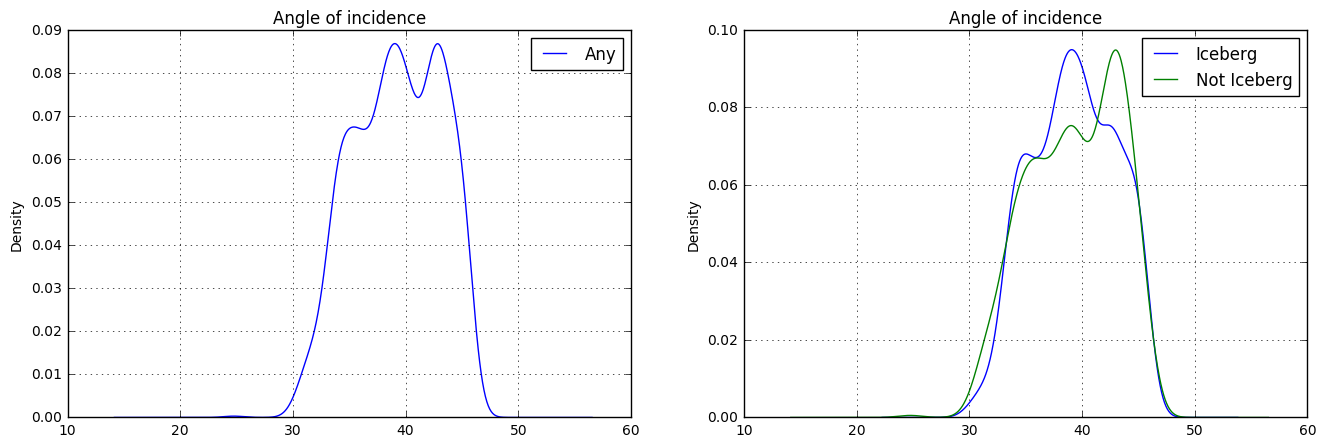

In [26]:
#获得入射角的分布
%matplotlib inline
P = train.groupby(ICEBERG)[ID].count().reset_index()
P['Percentage'] = 100*P[ID]/P[ID].sum()
print (P)
f, ax = plt.subplots(1,2,figsize=(16,5))
r = train.plot(kind="kde", y = ANGLE, ax=ax[0], label="Any", grid=True, title="Angle of incidence")
r = train[train[ICEBERG] == 1].plot(kind="kde", label="Iceberg", grid=True, y = ANGLE, ax=ax[1], title="Angle of incidence")
r = train[train[ICEBERG] == 0].plot(kind="kde", label="Not Iceberg", grid=True, y = ANGLE, ax=r)

In [27]:
#特征提取
MIN="min"
MAX="max"
MEAN="mean"
STD="std"
LAPLACE="laplacestd"
SOBEL0 = "sobelstd_x"
SOBEL1 = "sobelstd_y"
KURTOSIS = "kurtosis"
SKEW = "skew"
CORR = "pearson"
HYP = "hypstd"

AGG_COLS = [
    "%s_%s"%(BAND1,MAX), "%s_%s"%(BAND2,MAX),
    "%s_%s"%(BAND1,MIN), "%s_%s"%(BAND2,MIN),
    "%s_%s"%(BAND1,MEAN), "%s_%s"%(BAND2,MEAN),
    "%s_%s"%(BAND1,STD), "%s_%s"%(BAND2,STD),
    "%s_%s"%(BAND1,KURTOSIS), "%s_%s"%(BAND2,KURTOSIS),
    "%s_%s"%(BAND1,SKEW), "%s_%s"%(BAND2,SKEW),
    "%s_%s"%(BAND1,SOBEL0), "%s_%s"%(BAND2,SOBEL0),
    "%s_%s"%(BAND1,SOBEL1), "%s_%s"%(BAND2,SOBEL1),
    "%s_%s"%(BAND1,LAPLACE), "%s_%s"%(BAND2,LAPLACE),
    CORR,
    HYP,
]

# 体积
ISO = "iso"
ISO_COLS = ["%s_%s"%(BAND1,ISO), "%s_%s"%(BAND2,ISO)]
VOLUME = "vol"

FEATURES = [ANGLE, VOLUME] + AGG_COLS
FEATURES

['inc_angle',
 'vol',
 'band_1_max',
 'band_2_max',
 'band_1_min',
 'band_2_min',
 'band_1_mean',
 'band_2_mean',
 'band_1_std',
 'band_2_std',
 'band_1_kurtosis',
 'band_2_kurtosis',
 'band_1_skew',
 'band_2_skew',
 'band_1_sobelstd_x',
 'band_2_sobelstd_x',
 'band_1_sobelstd_y',
 'band_2_sobelstd_y',
 'band_1_laplacestd',
 'band_2_laplacestd',
 'pearson',
 'hypstd']

In [28]:
def iso(arr):
    image = img_as_float(np.reshape(np.array(arr), [75,75]))
    image = gaussian_filter(image,2.5)
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image 
    dilated = reconstruction(seed, mask, method='dilation')
    return image-dilated

In [29]:
# 索贝尔过滤器过滤后的标准偏差
def sobelstd(arr, axis=0):
    image = img_as_float(np.reshape(np.array(arr), [75,75]))
    sobelstd = sobel(image, axis=axis, mode='reflect', cval=0.0).ravel()
    return [sobelstd.std(), sobelstd.max(), sobelstd.mean()]


In [30]:
# 拉普拉斯过滤器过滤后的标准偏差
def lapacestd(arr):
    image = img_as_float(np.reshape(np.array(arr), [75,75]))
    lapacestd = laplace(image, mode='reflect', cval=0.0).ravel()
    return [lapacestd.std(), lapacestd.max(), lapacestd.mean()]

In [31]:
def volume(arr):
    return np.sum(arr)

In [32]:
def hypot(arr1, arr2):
    hyp = np.hypot(arr1, arr2)
    return [np.std(hyp), np.max(hyp), np.median(hyp)]

In [33]:
def computeAdditionalFeatures(df):
    # Aggregation on raw signal
    df["%s_%s"%(BAND1,MAX)] = df[BAND1].apply(lambda x: np.max(x))
    df["%s_%s"%(BAND2,MAX)] = df[BAND2].apply(lambda x: np.max(x))
    df["%s_%s"%(BAND1,MIN)] = df[BAND1].apply(lambda x: np.min(x))
    df["%s_%s"%(BAND2,MIN)] = df[BAND2].apply(lambda x: np.min(x))
    df["%s_%s"%(BAND1,MEAN)] = df[BAND1].apply(lambda x: np.mean(x))
    df["%s_%s"%(BAND2,MEAN)] = df[BAND2].apply(lambda x: np.mean(x))
    df["%s_%s"%(BAND1,STD)] = df[BAND1].apply(lambda x: np.std(x))
    df["%s_%s"%(BAND2,STD)] = df[BAND2].apply(lambda x: np.std(x))
    df["%s_%s"%(BAND1,KURTOSIS)] = df[BAND1].apply(lambda x: kurtosis(x))
    df["%s_%s"%(BAND2,KURTOSIS)] = df[BAND2].apply(lambda x: kurtosis(x))    
    df["%s_%s"%(BAND1,SKEW)] = df[BAND1].apply(lambda x: skew(x))
    df["%s_%s"%(BAND2,SKEW)] = df[BAND2].apply(lambda x: skew(x))     
    df["%s_%s"%(BAND1,SOBEL0)] = df[BAND1].apply(lambda x: sobelstd(x, axis=0)[0])
    df["%s_%s"%(BAND1,SOBEL1)] = df[BAND1].apply(lambda x: sobelstd(x, axis=1)[0])    
    df["%s_%s"%(BAND2,SOBEL0)] = df[BAND2].apply(lambda x: sobelstd(x, axis=0)[0])
    df["%s_%s"%(BAND2,SOBEL1)] = df[BAND2].apply(lambda x: sobelstd(x, axis=1)[0])   
    df["%s_%s"%(BAND1,LAPLACE)] = df[BAND1].apply(lambda x: lapacestd(x)[0])
    df["%s_%s"%(BAND2,LAPLACE)] = df[BAND2].apply(lambda x: lapacestd(x)[0])    
    df[CORR] = df.apply(lambda row: np.corrcoef(x=row[BAND1], y=row[BAND2])[1,0], axis=1)
    df[HYP] = df.apply(lambda row: hypot(row[BAND1], row[BAND2])[0], axis=1)
    
    
    df["%s_%s"%(BAND1,ISO)] = df[BAND1].apply(lambda x: iso(x))
    df["%s_%s"%(BAND2,ISO)] = df[BAND2].apply(lambda x: iso(x))
    df[VOLUME] = (df["%s_%s"%(BAND1,ISO)] + df["%s_%s"%(BAND2,ISO)]).apply(volume)
    
    
    cleanDF = df.dropna()
    ret = cleanDF[FEATURES].copy(deep=True)
    ret_labels = None
    if ICEBERG in cleanDF.columns:
        ret_labels = cleanDF[[ICEBERG]]
    ret_ids = cleanDF[[ID]]
    ret_cols = ret.columns
            
    return ret, ret_labels, ret_ids

In [34]:
def read_and_normalize_train_data(train_df):
    featuresDF, labelsDF, idsDF = computeAdditionalFeatures(train_df.copy(deep=True))
    train_features = featuresDF.as_matrix()
    train_target = labelsDF.as_matrix()
    train_id = idsDF.as_matrix()
    print("Features size: %s/%s"%(str(train_features.shape), str(train_target.shape)))
    return train_features, train_target, train_id, featuresDF[FEATURES].columns

In [35]:
def fit_evaluate_model_lgbm(X_train, Y_train, X_valid, Y_valid, train_data_columns, model_path, num_fold, importance=False):
    X_trainDF = pd.DataFrame(X_train, columns=train_data_columns)
    X_validDF = pd.DataFrame(X_valid, columns=train_data_columns)
    train_dataset = lgb.Dataset(X_trainDF, Y_train.reshape(Y_train.shape[0]))
    test_dataset = lgb.Dataset(X_validDF, Y_valid.reshape(Y_valid.shape[0]))
    # Fit
    evals_result = {}
    params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting': 'gbdt',
            'learning_rate': 0.1,
            'num_rounds': 150,
            'early_stopping_rounds': 100
    }
    gbm = lgb.train(params, train_dataset, 
                    valid_sets=test_dataset, 
                    evals_result=evals_result,
                    verbose_eval=50)
    
    predict_y_proba_gbm = gbm.predict(X_valid, num_iteration=gbm.best_iteration) # Proba of class 1
    predict_y_gbm = np.where(predict_y_proba_gbm.reshape((predict_y_proba_gbm.shape[0])) > 0.5, 1, 0)

    score_ll = metrics.log_loss(Y_valid, predict_y_proba_gbm)
    score_ac = metrics.accuracy_score(Y_valid, predict_y_gbm)
    score_pr = metrics.precision_score(Y_valid, predict_y_gbm)
    score_re = metrics.recall_score(Y_valid, predict_y_gbm)
    score = [score_ll, score_ac, score_pr, score_re]
    
    if (importance == True):
        ax = lgb.plot_importance(gbm, max_num_features=20, figsize=(16, 5))
        plt.show()
    
    gbmDF = pd.DataFrame([tuple(gbm.feature_importance())], columns= gbm.feature_name())
    gbmDF.sort_index(axis=1, inplace=True)

    return score, gbmDF, gbm

In [36]:
def run_cross_validation_create_models(train_df, model_path, nfolds=4, break_fold=-1, importance=False):
    train_data, train_target, train_id, train_data_columns = read_and_normalize_train_data(train_df)
    train_target = train_target.ravel()
    kf = StratifiedKFold(n_splits=nfolds, random_state=None, shuffle=True)
    num_fold = 0
    sum_score_ll = 0
    sum_score_ac = 0
    sum_score_pr = 0
    sum_score_re = 0
    scores = []
    models = []
    importanceDF = pd.DataFrame()
    for train_index, test_index in kf.split(train_data, train_target):
        num_fold += 1
        print('\n==> Start KFold number {} from {}'.format(num_fold, nfolds))
        X_train = train_data[train_index]
        Y_train = train_target[train_index]
        X_valid = train_data[test_index]
        Y_valid = train_target[test_index]
        print("Train size: %s/%s"%(str(X_train.shape), str(Y_train.shape)))
        print("Valid size: %s/%s"%(str(X_valid.shape), str(Y_valid.shape)))
        score, impDF, m = fit_evaluate_model_lgbm(X_train,Y_train, X_valid, Y_valid, train_data_columns, 
                                   model_path, num_fold, importance=False)
        models.append(m)
        if len(importanceDF) == 0:
            importanceDF = impDF
        else:
            importanceDF = pd.concat([importanceDF, impDF])
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        sum_score_ll += score[0]*len(test_index)
        sum_score_ac += score[1]*len(test_index)
        sum_score_pr += score[2]*len(test_index)
        sum_score_re += score[3]*len(test_index)
        scores.append(score)
        # Break KFold loop
        if (break_fold > 0) & (break_fold == num_fold):
            break
    score_ll = sum_score_ll/len(train_data)
    score_ac = sum_score_ac/len(train_data)
    score_pr = sum_score_pr/len(train_data)
    score_re = sum_score_re/len(train_data)
    print('\nCV average scores:')
    print('log_loss: %s\naccuracy: %s\nprecision: %s\nrecall: %s\n'%(score_ll, score_ac, score_pr, score_re))
    return scores, importanceDF, models

In [37]:
def read_and_normalize_test_data(test_df):
    featuresDF, labelsDF, idsDF = computeAdditionalFeatures(test_df.copy(deep=True))
    test_features = featuresDF.as_matrix()
    test_id = idsDF.as_matrix()
    print("Features size: %s/%s"%(str(test_features.shape), str(test_id.shape)))
    return test_features, test_id, featuresDF[FEATURES].columns

In [38]:
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    aPD = pd.DataFrame(a, columns = ["%s_%d"%(ICEBERG, 1)])
    for i in range(1, nfolds):
        a = a + np.array(data[i])
        aPD["%s_%d"%(ICEBERG, i+1)] = np.array(data[i])
    a = a / nfolds*1.0
    return a, aPD

-----------   Seed 1337   ----------------
Features size: (1471, 22)/(1471, 1)

==> Start KFold number 1 from 10
Train size: (1323, 22)/(1323,)
Valid size: (148, 22)/(148,)
[50]	valid_0's binary_logloss: 0.236632
[100]	valid_0's binary_logloss: 0.208414
Test loss: 0.208414005171
Test accuracy: 0.912162162162

==> Start KFold number 2 from 10
Train size: (1323, 22)/(1323,)
Valid size: (148, 22)/(148,)
[50]	valid_0's binary_logloss: 0.278576
[100]	valid_0's binary_logloss: 0.25269
Test loss: 0.252689889952
Test accuracy: 0.878378378378

==> Start KFold number 3 from 10
Train size: (1323, 22)/(1323,)
Valid size: (148, 22)/(148,)
[50]	valid_0's binary_logloss: 0.237416
[100]	valid_0's binary_logloss: 0.206723
Test loss: 0.206723291293
Test accuracy: 0.891891891892

==> Start KFold number 4 from 10
Train size: (1324, 22)/(1324,)
Valid size: (147, 22)/(147,)
[50]	valid_0's binary_logloss: 0.261731
[100]	valid_0's binary_logloss: 0.221665
Test loss: 0.221664505837
Test accuracy: 0.89795918367

C:\Users\pc\ana\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
C:\Users\pc\ana\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


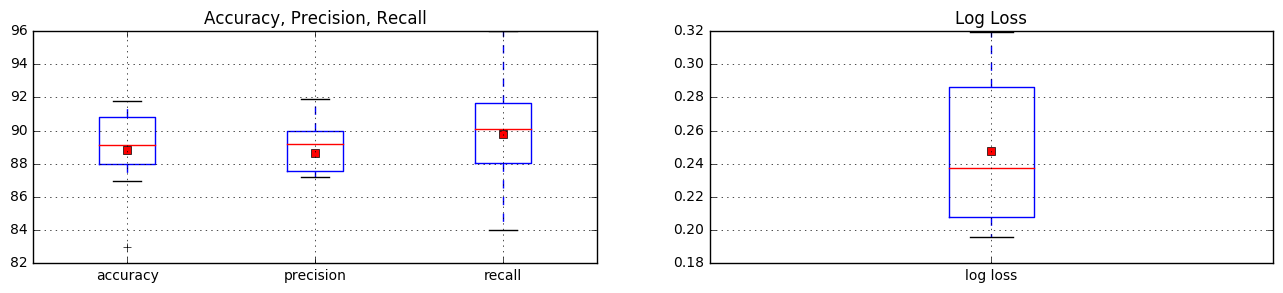

CV val Log loss: 0.247527407781


,band_1_kurtosis,band_1_laplacestd,band_1_max,band_1_mean,band_1_min,band_1_skew,band_1_sobelstd_x,band_1_sobelstd_y,band_1_std,band_2_kurtosis,...,band_2_mean,band_2_min,band_2_skew,band_2_sobelstd_x,band_2_sobelstd_y,band_2_std,hypstd,inc_angle,pearson,vol
0,39,37,26,55,25,9,24,78,33,63,...,33,8,14,40,10,5,23,74,25,49
0,48,34,24,44,26,9,18,78,33,49,...,35,14,20,37,6,3,32,71,21,56
0,40,39,27,52,23,10,17,78,30,58,...,35,4,16,39,10,9,43,57,15,64
0,42,39,26,59,35,17,19,70,28,48,...,34,9,12,43,12,10,24,72,18,46
0,42,34,26,56,27,9,17,73,37,51,...,38,7,15,36,8,8,32,62,22,55


In [39]:
NFOLDS = 10
seed = 1337
np.random.seed(seed)
print("-----------   Seed %d   ----------------"%seed)
model_path = "%s.cv%d.%d"%(initial_model_path, NFOLDS, seed)
os.makedirs(model_path, exist_ok=True)

scores, importanceDF, models = run_cross_validation_create_models(train, model_path, nfolds=NFOLDS, break_fold=-1, importance = True)
scores = np.array(scores)
scores_loss = scores[:,0]
scores_other = scores[:,1:4]

box_loss = pd.DataFrame(scores_loss, columns=["log loss"])
box_other = pd.DataFrame(scores_other*100.0, columns=["accuracy", "precision", "recall"])
f, ax = plt.subplots(1, 2, figsize=(16,3))
box_other.boxplot(ax=ax[0], showmeans=True)
ax[0].set_title("Accuracy, Precision, Recall")
box_loss.boxplot(ax=ax[1], showmeans=True)
ax[1].set_title("Log Loss")
plt.show()
print("CV val Log loss: %s"%(np.mean(scores_loss)))

importanceDF.head()

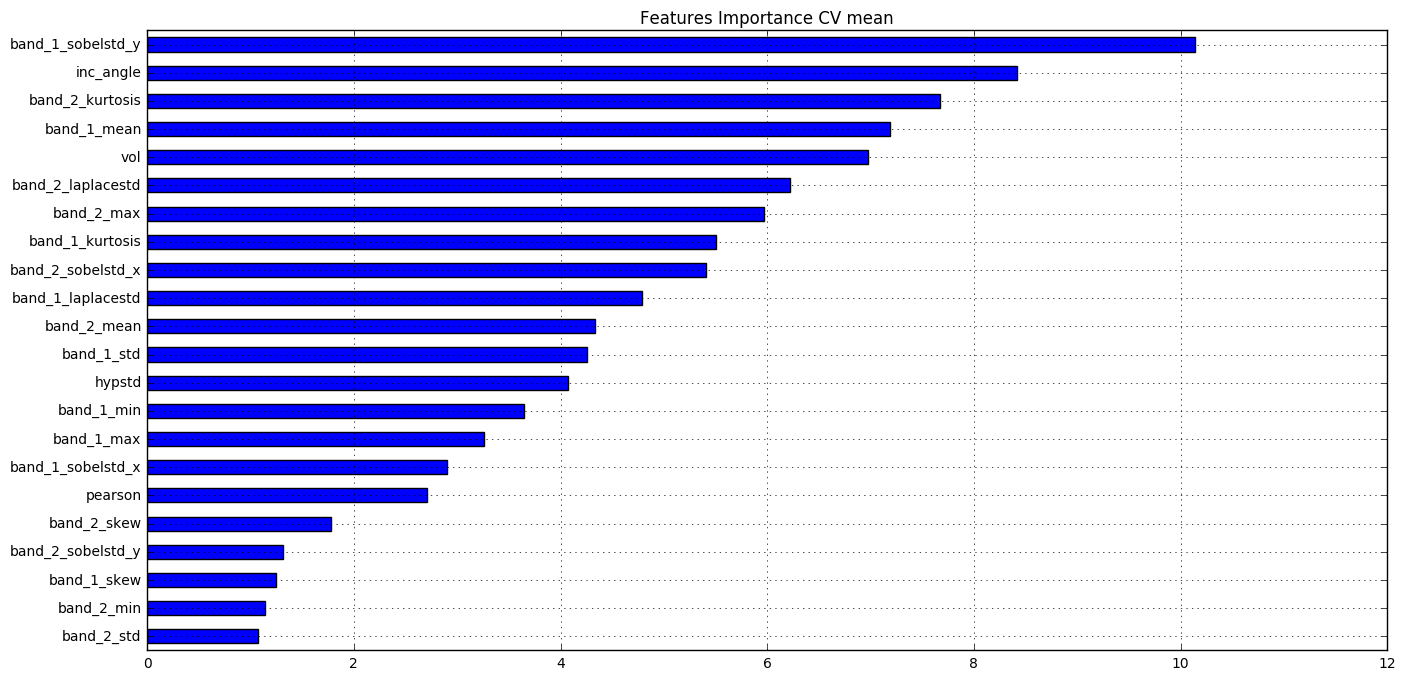

In [40]:
mgbmDF = pd.DataFrame(importanceDF.mean(), columns=["Importance"])
mgbmDF = mgbmDF.apply(lambda x: 100.0 * x / float(x.sum()))
mgbmDF.sort_values(by=["Importance"], ascending=[True]).plot(kind="barh", legend=False, grid=True, figsize=(16,8))
a = plt.title("Features Importance CV mean")

In [42]:
test = pd.read_json(r'C:/kaggle/ice/test.json')

X_test, X_test_id, X_test_columns = read_and_normalize_test_data(test)

yfull_proba_train = []
yfull_proba_test = []
yfull_label_test = []
num_fold = 0

for model in models:
    num_fold += 1
    print('==> Start KFold number {} from {}'.format(num_fold, NFOLDS))
    
    predicted_test = model.predict(X_test, num_iteration=model.best_iteration) # Proba of class 1
    predicted_test_label = np.where(predicted_test.reshape((predicted_test.shape[0])) > 0.5, 1, 0)
    yfull_proba_test.append(predicted_test)
    yfull_label_test.append(predicted_test_label)

Features size: (8424, 22)/(8424, 1)
==> Start KFold number 1 from 10
==> Start KFold number 2 from 10
==> Start KFold number 3 from 10
==> Start KFold number 4 from 10
==> Start KFold number 5 from 10
==> Start KFold number 6 from 10
==> Start KFold number 7 from 10
==> Start KFold number 8 from 10
==> Start KFold number 9 from 10
==> Start KFold number 10 from 10


In [43]:
kfold_cols = ["%s_%d"%(ICEBERG, i) for i in range(1, NFOLDS + 1) ]
predicted_test_mean, predicted_test_pd = merge_several_folds_mean(yfull_proba_test, NFOLDS)
predicted_test_pd.head()

,is_iceberg_1,is_iceberg_2,is_iceberg_3,is_iceberg_4,is_iceberg_5,is_iceberg_6,is_iceberg_7,is_iceberg_8,is_iceberg_9,is_iceberg_10
0,0.030146,0.033014,0.034068,0.026198,0.030798,0.038039,0.035740,0.025492,0.036011,0.043778
1,0.749340,0.648410,0.635222,0.826679,0.854096,0.795168,0.610391,0.626871,0.752993,0.816077
2,0.705120,0.472933,0.564437,0.540421,0.500742,0.603328,0.597386,0.521903,0.595170,0.418038
3,0.971062,0.987473,0.990288,0.981085,0.976872,0.988750,0.975324,0.957545,0.963313,0.983838
4,0.708903,0.802473,0.810361,0.789235,0.688317,0.561924,0.731501,0.770192,0.867494,0.546055


In [44]:
submission = pd.DataFrame()
submission[ID]=test[ID]
submission[ICEBERG]=predicted_test_mean
submission.to_csv("submissionlgbmv1.csv", index=False, sep=",", decimal=".")

In [3]:
#inc_angle
df= pd.read_csv(r'C:/kaggle/ice/submission54.csv')
train = pd.read_json(r'C:/kaggle/ice/train.json')
test = pd.read_json(r'C:/kaggle/ice/test.json')
train.replace(to_replace="na", value=np.nan, inplace=True)
train.dropna(inplace=True)
df = pd.merge(test, df, on='id')
df.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400,0.005586
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072,0.031688
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433,0.001000
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900,0.999000
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874,0.022151


In [5]:
a = set(float(c) for c in train[train["is_iceberg"]==0]["inc_angle"])
b = set(float(c) for c in train[train["is_iceberg"]==1]["inc_angle"])
c = set(float(c) for c in test["inc_angle"] if len(str(c))<=7)

test.drop(test[~test["inc_angle"].isin(c)].index,inplace=True)#。
df

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400,0.005586
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072,0.031688
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433,0.001000
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900,0.999000
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874,0.022151
5,"[-18.13534927368164, -18.13534927368164, -18.1...","[-14.650325775146484, -14.650325775146484, -14...",a8d9b1fd,35.933020,0.051959
6,"[-24.565174, -26.567524, -25.946882, -26.89542...","[-32.915886, -35.194798, -32.272282, -28.7505,...",29e7727e,42.414200,0.003916
7,"[-20.162964, -18.16898, -17.023144, -17.023216...","[-30.905346, -28.406647, -25.381365, -28.77645...",92a51ffb,33.638300,0.999000
8,"[-21.920645, -21.737827, -21.383303, -21.73792...","[-25.53537, -28.514198, -27.75848, -31.280354,...",c769ac97,41.107600,0.001000
9,"[-14.811565, -16.318594, -17.082613, -16.41037...","[-22.617977, -21.065811, -27.914198, -25.24334...",aee0547d,34.966400,0.001000


In [6]:
#当有了第一次模型训练出的结果之后，并且测试集的入射角在训练集中可以找到
ans = []
for angle, prob in zip(df.inc_angle, df.is_iceberg):
    #通过相同的角度在训练集中的表现来推断在测试集中相应的表现
    if float(angle) in a and float(angle) not in b and prob < 0.5:
        ans.append(0.01)
    elif float(angle) not in a and float(angle) in b and prob > 0.5:
        ans.append(0.99)
    else:
        ans.append(prob)
        
df['is_iceberg'] = ans

df[['id','is_iceberg']].to_csv('final.csv', index=False)